# Approximate Manifold Sampling

Sample from a manifold with **uniform** density on it using Hug and Tangential Hug

In [98]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand
from numpy.linalg import norm, solve, inv, det
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold

### Settings

In [99]:
# Various settings
z = 0.02                 # Density value on contour (0.01)
scale = 1.0              # Scale for tangential proposal in Zappa
n = 1000                  # Number of Zappa samples
tol = 1.48e-08           # Tolerance for projection optimization
a_guess = np.array([0])  # Initial guess of a for projection
T = 0.5                  # Total integration time for one iteration of Hug
B = 1                    # Number of sub-iterations per hug iteration
alpha = 0.95              # Percentage of gradient to remove
eps = 0.01                # Error allowed on the manifold
hug_scale = 1.0          # Scale for proposal in hug  0.05
thug_scale = 1.0         # Scale for proposal in tangential hug  1.0

In [3]:
# Perfect manifold is just z-contour of a MVN
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
manifold = RotatedEllipse(mu, Sigma, z)

### Perfect Manifold Sampling

$$
\mathcal{M}_1 = \left\{(x,y)\in\mathbb{R}^2\,:\, \mathcal{N}_{\mu, \Sigma}(x, y) = z\right\}
$$

In [4]:
# Initial point on manifold
x0 = manifold.to_cartesian(np.random.uniform(0, 2*np.pi))

# Helper functions
logf = lambda xy: 0.     # Uniform density on manifold
logp = lambda xy: logp_scale(xy, sigma=scale)

In [5]:
samples1 = zappa_sampling(x0, manifold, logf, logp, n, scale, tol, a_guess)

In [6]:
ZappaObj = Zappa(x0, manifold, logf, logp, n, scale, tol, a_guess)
out = ZappaObj.sample()
samples1 = out['samples']
vxs = out['vxs']

### Hug Algorithm

In [7]:
def Hug(x0, T, B, n, q_sample, logq, logpi, grad_log_pi):
    """
    Standard Hug Kernel. This uses no preconditioning. This is ONE STEP of the hug kernel.
    Returns a triplet (x, v, a) where x is the new sample, v is the velocity at the new sample
    and a is a binary flag indicating successful acceptance (a=1) or rejection (a=0).

    x0 : Numpy Array
         Point from which to do 1 step fo Hug. Basically the difference between self.x0 and
         x0 is that self.x0 is the starting point of the whole algorithm, while x0 is just the 
         starting point for this Hug.
    """
    samples = x0
    acceptances = np.zeros(n)
    allpoints = x0
    for i in range(n):
        # Draw velocity
        v0 = q_sample()
        
        # Housekeeping
        v = v0
        x = x0
        # Acceptance ratio
        logu = np.log(rand())
        # Compute step size
        delta = T / B

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Append it
            allpoints = np.vstack((allpoints, x))
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2
            # Append
            allpoints = np.vstack((allpoints, x))

        if logu <= logpi(x) + logq(v) - logpi(x0) - logq(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples, acceptances, allpoints

In [8]:
# Proposal density is spherical normal
q_hug = multivariate_normal(mean=np.zeros(2), cov=hug_scale*np.eye(2))
q_sample_h = q_hug.rvs
logq_h = q_hug.logpdf
# Target is just the MVN whose contour we are sampling
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)

In [9]:
samples2, a2, p2 = Hug(x0, T, B, n, q_sample_h, logq_h, logpi, grad_log_pi)

### Tangential Hug

In [10]:
def HugTangential(x0, T, B, n, alpha, q_sample, logq, logpi, grad_log_pi):
    """
    Spherical Hug. Notice that it doesn't matter whether we use the gradient of pi or 
    grad log pi to tilt the velocity.
    """
    samples = x0
    acceptances = np.zeros(n)
    allpoints = x0
    for i in range(n):
        # Draw velocity spherically
        v0s = q_sample()
        # Compute normalized gradient at x0
        g = grad_log_pi(x0)
        g = g / norm(g)
        # Tilt velocity
        v0 = v0s - alpha * g * (g @ v0s)
        # Housekeeping
        v = v0
        x = x0
        # Acceptance ratio
        logu = np.log(rand())
        # Compute step size
        delta = T / B

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Append
            allpoints = np.vstack((allpoints, x))
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2
            # Append
            allpoints = np.vstack((allpoints, x))
        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (alpha / (1 - alpha)) * g * (g @ v)
        # Need to compute the density of the tilted proposals
        standard_MVN = multivariate_normal(np.zeros(2), np.eye(2))
        logq0 = lambda xy: standard_MVN.logpdf(xy) 
        logq  = lambda xy: standard_MVN.logpdf(xy)
        if logu <= logpi(x) + logq(v) - logpi(x0) - logq0(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples, acceptances, allpoints

In [11]:
# Proposal density is spherical normal before being squeezed
q_thug = multivariate_normal(mean=np.zeros(2), cov=thug_scale*np.eye(2))
q_sample_th = q_thug.rvs
logq_th = q_thug.logpdf

In [12]:
samples3, a3, p3 = HugTangential(x0, T, B, n, alpha, q_sample_th, logq_th, logpi, grad_log_pi) 

### Results

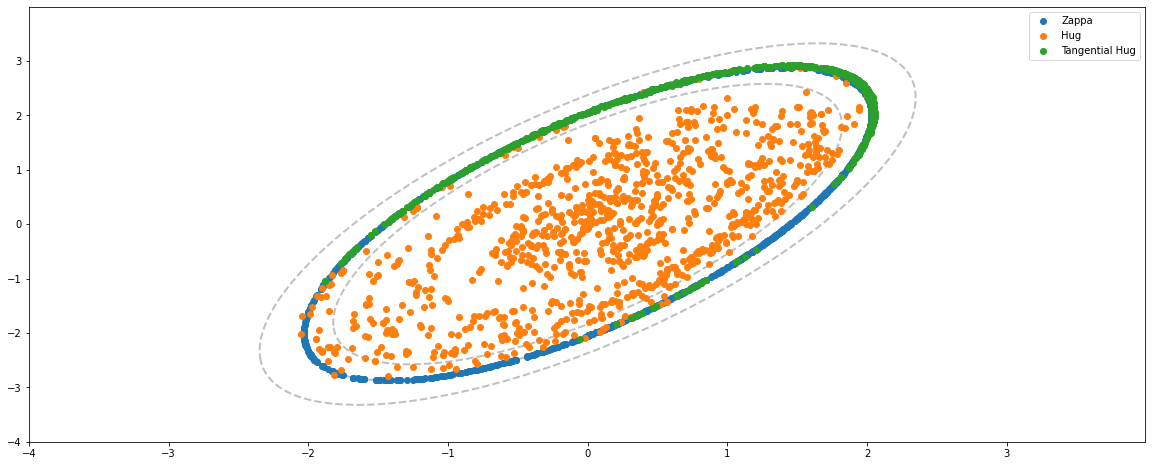

In [13]:
xlims=[-4,4]
ylims=[-4,4]
step = 0.01
# Grid of points for contour plot
x, y = np.mgrid[xlims[0]:xlims[1]:step, ylims[0]:ylims[1]:step]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z+eps], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z-eps], alpha=0.5, zorder=1, colors='gray')
ax.scatter(*samples1.T, label="Zappa")
ax.scatter(*samples2.T, label="Hug")
ax.scatter(*samples3.T, label="Tangential Hug")
ax.legend()
plt.show()

In [14]:
ZappaObj.acceptance_rate()

0.881

In [15]:
np.sum(a2) / n

0.981

In [16]:
np.sum(a3) / n

0.541

In [90]:
delta=1.0

In [91]:
v0 = q_sample_h()
g = grad_log_pi(x0)
g_hat = g / norm(g)
x_new = x0 + delta * v0/2
g_new = grad_log_pi(x_new)
g_new_hat = g_new / norm(g_new)
v_new = v0 - 2 * (v0 @ g_new_hat) *g_new_hat
print(v_new)
# Compute it in a new way
v0 + (8 *(logpi(x_new) - logpi(x0)) / (delta * norm(g))) * g_hat

[-0.55483967 -0.56162389]


array([-0.45716641, -0.64543248])

In [92]:
def a(x, v):
    g = grad_log_pi(x)
    g_norm = norm(g)
    g_hat = g / g_norm
    return - v @ solve(Sigma, v) *  g_hat / g_norm

In [93]:
delta * a(x0, v0)

array([ 0.06595805, -0.05310252])

In [94]:
delta * a(x_new, v0)

array([ 0.06526529, -0.05877757])

In [95]:
- 2 * grad_log_pi(x_new) * (grad_log_pi(x_new) @ v0) / (norm(grad_log_pi(x_new))**2)

array([-0.05416052,  0.04877667])

In [96]:
- 2 * g_hat * (g_new_hat @ v0)

array([-0.05677385,  0.04570837])

In [97]:
- 8 * (logpi(x_new) - logpi(x0)) * grad_log_pi(x0) / norm(grad_log_pi(x0))

array([-0.13544653,  0.10904738])

### Distance Manifold

$$
\mathcal{M}_\epsilon = \left\{(x,y)\in\mathbb{R}^2\,:\, |\mathcal{N}_{\mu, \Sigma}(x,y) - z| = \epsilon\right\}
$$

In [112]:
# Perfect Distance Manifold
min_eps = 0.0001
DM = Manifold(m=1, d=1)
DM.q = lambda xy: abs(target.pdf(xy) - z)

In [113]:
# Recycle x0 to be the first point on the manifold
DM.q(x0)

0.0

In [118]:
def grad_log_pi(xy):
    # instantiate manifold at xy
    manifold = RotatedEllipse(mu, Sigma, target.pdf(xy))
    # Find its gradient there
    J = manifold.Q(xy)
    vec = np.array([target.pdf(xy) - z])
    return J @ vec

In [119]:
samples_dmh, _, _ = Hug(x0, T, B, n, q_sample, logq, logpi, grad_log_pi)

In [120]:
# Notice that tangential hug cannot start on the distance manifold because it needs to compute a gradient at
# the start, which doesn't exist. Instead, we perturb x0 ? Or we would do 1 iteration of Hug and then use THUG.
x02 = x0 + np.array([0.001, -0.001])
samples_dmth, _, _ = HugTangential(x02, T, B, n, 0.9, q_sample, logq, logpi, grad_log_pi)

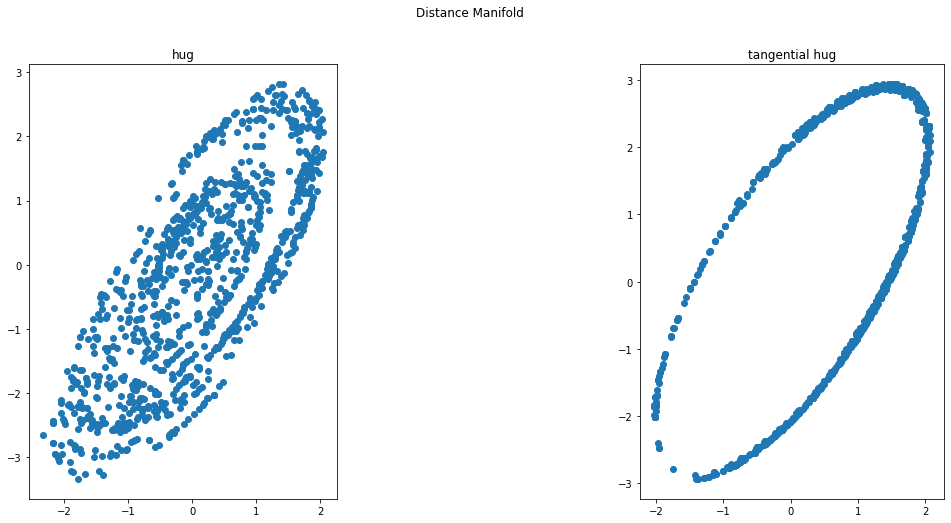

In [121]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
ax[0].scatter(*samples_dmh.T)
ax[0].set_aspect("equal")
ax[0].set_title("hug")
ax[1].scatter(*samples_dmth.T)
ax[1].set_aspect("equal")
ax[1].set_title("tangential hug")
fig.suptitle("Distance Manifold")
plt.show()

### Mixture of Gaussians

In [211]:
mu1 = np.array([1, 1])
Sigma1 = np.eye(2)
mu2 = np.array([-1, -1])
Sigma2 = np.eye(2)
G1 = multivariate_normal(mu1, Sigma1)
G1_grad = lambda xy: - G1.pdf(xy) * solve(Sigma1, xy - mu1)
G2 = multivariate_normal(mu2, Sigma2)
G2_grad = lambda xy: - G2.pdf(xy) * solve(Sigma2, xy - mu2)
beta = 0.5
z_mg = 0.058
MG = lambda xy: beta * G1.pdf(xy) + (1 - beta) * G2.pdf(xy)

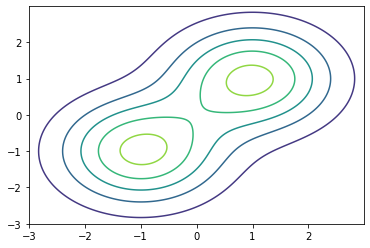

In [208]:
plt.contour(*prep_contour([-3, 3], [-3, 3], 0.01, MG))
plt.show()

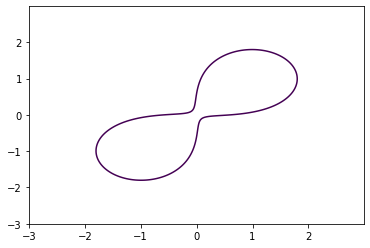

In [234]:
plt.contour(*prep_contour([-3, 3], [-3, 3], 0.01, MG), levels=[z_mg])
plt.show()

##### Perfect Sampling

In [336]:
MGM = Manifold(m=1, d=1)
MGM.q = lambda xy: MG(xy) - z_mg
MGM.Q = lambda xy: (beta * G1_grad(xy) + (1 - beta) * G2_grad(xy)).reshape(-1, 1)

In [337]:
x0mg = fsolve(lambda xy: np.array([MGM.q(xy), 0]), np.array([-2, -1]))

In [338]:
samples_mg = zappa_sampling(x0mg, MGM, logf, logp, n, scale, tol, a_guess)

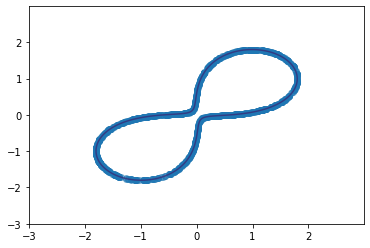

In [339]:
plt.contour(*prep_contour([-3, 3], [-3, 3], 0.01, MG), levels=[z_mg], alpha=0.5)
plt.scatter(*samples_mg.T, alpha=0.5)
plt.show()

##### Hug

In [353]:
logpi_mg = lambda xy: np.log(MG(xy))
grad_log_pi_mg = lambda xy: (1 / (MG(xy))) * (beta * G1_grad(xy) + (1 - beta) * G2_grad(xy))

In [354]:
samples_h_mg, _, _ = Hug(x0mg, T, B, n, q_sample_h, logq_h, logpi_mg, grad_log_pi_mg)

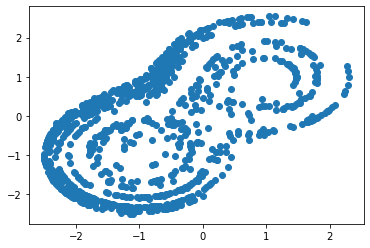

In [355]:
plt.scatter(*samples_h_mg.T)
plt.show()

##### Tangential Hug

In [356]:
samples_th_mg, _, _ = HugTangential(x0mg, T, B, n, alpha, q_sample_th, logq_th, logpi_mg, grad_log_pi_mg)

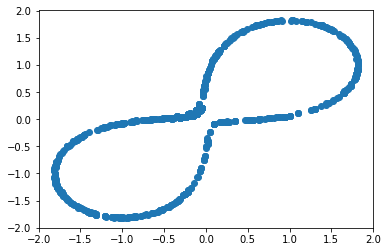

In [357]:
plt.scatter(*samples_th_mg.T)
plt.show()

### Hug and Tangential Hug with same samples

In [346]:
# Might need different proposal functions as input?

In [281]:
def Hug_and_THUG(x00, T, B, n, alpha, q_sample, logq, logpi, grad_log_pi):
    """Performs both"""
    # Sample same uniform for MH step
    logus = np.log(np.random.uniform(size=n))
    # Sample all the spherical velocities beforehand
    v_sphericals = np.vstack([q_sample() for _ in range(n)])
    # Store samples and acceptances
    hsamples = x00
    tsamples = x00
    hacceptances = np.zeros(n)
    tacceptances = np.zeros(n)
    ##### HUG ######
    x0 =x00
    for i in range(n):
        # Draw velocity
        v0 = v_sphericals[i]   
        # Housekeeping
        v = v0
        x = x0
        # Acceptance ratio
        logu = logus[i]
        # Compute step size
        delta = T / B

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2

        if logu <= logpi(x) + logq(v) - logpi(x0) - logq(v0):
            hsamples = np.vstack((hsamples, x))
            hacceptances[i] = 1         # Accepted!
            x0 = x
        else:
            hsamples = np.vstack((hsamples, x0))
            hacceptances[i] = 0         # Rejected
    ##### THUG #####
    x0 = x00
    for i in range(n):
        # Draw velocity spherically
        v0s = v_sphericals[i]
        # Compute normalized gradient at x0
        g = grad_log_pi(x0)
        g = g / norm(g)
        # Tilt velocity
        v0 = v0s - alpha * g * (g @ v0s)
        # Housekeeping
        v = v0
        x = x0
        # Acceptance ratio
        logu = logus[i]
        # Compute step size
        delta = T / B

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2
        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (alpha / (1 - alpha)) * g * (g @ v)
        # Need to compute the density of the tilted proposals
        standard_MVN = multivariate_normal(np.zeros(2), np.eye(2))
        logq0 = lambda xy: standard_MVN.logpdf(xy) 
        logq  = lambda xy: standard_MVN.logpdf(xy)
        if logu <= logpi(x) + logq(v) - logpi(x0) - logq0(v0):
            tsamples = np.vstack((tsamples, x))
            tacceptances[i] = 1         # Accepted!
            x0 = x
        else:
            tsamples = np.vstack((tsamples, x0))
            tacceptances[i] = 0         # Rejected
    return hsamples, tsamples, hacceptances, tacceptances

In [311]:
# Proposal density is spherical normal
scaling = 1.0
q_sample_h = multivariate_normal(mean=np.zeros(2), cov=scaling*np.eye(2)).rvs
logq_h = multivariate_normal(mean=np.zeros(2), cov=scaling*np.eye(2)).logpdf
# Target is just the MVN whose contour we are sampling
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)

In [318]:
hs, ts, ha, ta = Hug_and_THUG(x0, T, B, n, alpha, q_sample_h, logq_h, logpi, grad_log_pi) 

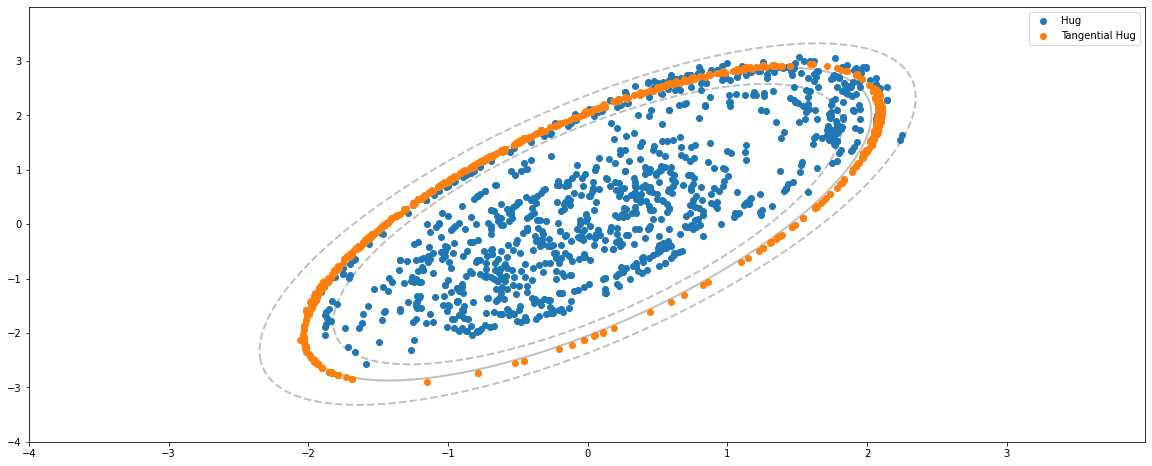

In [319]:
xlims=[-4,4]
ylims=[-4,4]
step = 0.01
# Grid of points for contour plot
x, y = np.mgrid[xlims[0]:xlims[1]:step, ylims[0]:ylims[1]:step]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z+eps], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z-eps], alpha=0.5, zorder=1, colors='gray')
ax.scatter(*hs.T, label="Hug")
ax.scatter(*ts.T, label="Tangential Hug")
ax.legend()
plt.show()

In [320]:
print("Hug AR: {:.3} \nTHug AR: {:.3}".format(np.sum(ha) / n, np.sum(ta/n)))

Hug AR: 0.976 
THug AR: 0.619


### Eight-shaped Manifold

In [180]:
# Create manifold
Eight = Manifold(m=1, d=1)
Eight.q = lambda xy: xy[0]**4 - xy[0]**2 + xy[1]**2 
Eight.Q = lambda xy: np.array([[4*xy[0]**3 - 2*xy[0]], [2*xy[1]]])
Eight.to_cartesian = lambda t: np.array([np.sin(t), np.sin(t)*np.cos(t)])
# Get a starting poitn on the manifold
x0_eight = Eight.to_cartesian(np.random.uniform(0, 2*np.pi))
# Sample from it
eight_samples = zappa_sampling(x0_eight, Eight, logf, logp, 1000, scale, tol, a_guess)

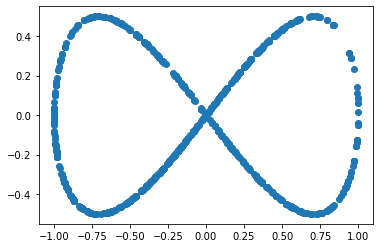

In [181]:
plt.scatter(*eight_samples.T)

In [182]:
eight_logpi = multivariate_normal(np.zeros(2), np.eye(2)).logpdf

In [ ]:
Hug(x0_eight, T, B, n, q_sample_h, logq_h, eight_logpi, )

# Experiment 1: True Manifold

In [364]:
def NoAR(x00, T, B, n, alpha, q_sample, logq, logpi, grad_log_pi):
    """
    Hug and THug without Accept-Reject.
    """
    hsamples = x00
    tsamples = x00
    v_sphericals = np.vstack([q_sample() for _ in range(n)])

    ### HUG
    x0 = x00
    for i in range(n):
        # Draw velocity
        v0 = v_sphericals[i]
        
        # Housekeeping
        v = v0
        x = x0
        # Compute step size
        delta = T / B

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2
        hsamples = np.vstack((hsamples, x))
    ### THUG
    x0 = x00
    for i in range(n):
        # Draw velocity spherically
        v0s = v_sphericals[i]
        # Compute normalized gradient at x0
        g = grad_log_pi(x0)
        g = g / norm(g)
        # Tilt velocity
        v0 = v0s - alpha * g * (g @ v0s)
        # Housekeeping
        v = v0
        x = x0
        # Compute step size
        delta = T / B

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2
        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (alpha / (1 - alpha)) * g * (g @ v)
        tsamples = np.vstack((tsamples, x))
        
    return hsamples, tsamples

In [367]:
# Various settings
z = 0.02                 # Density value on contour (0.01)

In [368]:
# Find initial point on the manifold
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
manifold = RotatedEllipse(mu, Sigma, z)
x0 = manifold.to_cartesian(np.random.uniform(0, 2*np.pi))

In [369]:
# Proposal density is spherical normal
scaling = 1.0
q_sample_h = multivariate_normal(mean=np.zeros(2), cov=scaling*np.eye(2)).rvs
logq_h = multivariate_normal(mean=np.zeros(2), cov=scaling*np.eye(2)).logpdf
# Target is just the MVN whose contour we are sampling
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)

In [371]:
hsamples, tsamples = NoAR(x0, 1.0, 5, 1, 0.95, q_sample_h, logq_h, logpi, grad_log_pi) 

In [380]:
hsamples

array([[0.94485071, 2.75205785],
       [1.32074744, 2.86972391]])

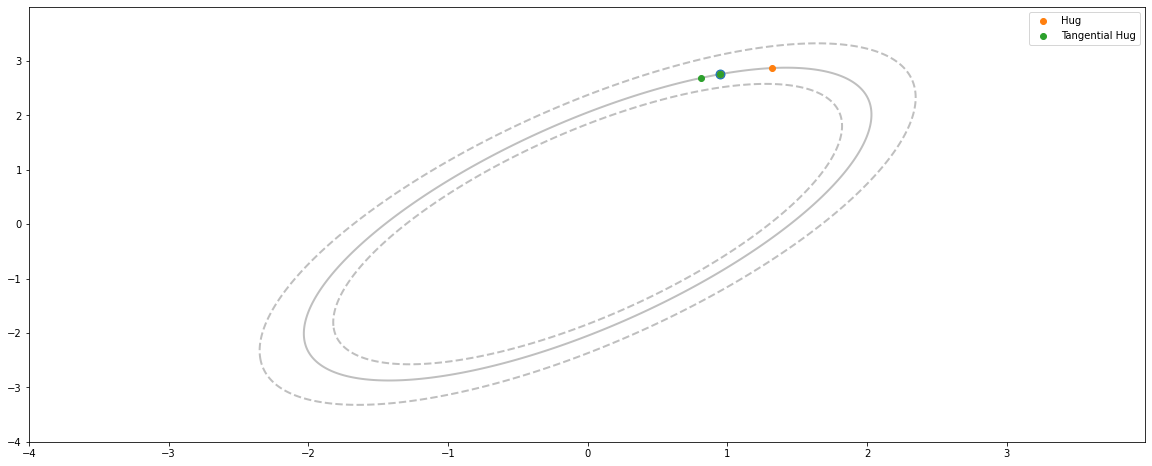

In [379]:
xlims=[-4,4]
ylims=[-4,4]
step = 0.01
# Grid of points for contour plot
x, y = np.mgrid[xlims[0]:xlims[1]:step, ylims[0]:ylims[1]:step]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z+eps], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z-eps], alpha=0.5, zorder=1, colors='gray')
ax.scatter(*x0, s=80)
ax.scatter(*hsamples.T, label="Hug")
ax.scatter(*tsamples.T, label="Tangential Hug")
ax.legend()
plt.show()

# Experiment 1: Distance Manifold